# ndvi_smol

### Here we gather Sentinel-2 data to calculate plot ndvi 

In [1]:
# # For Sentinel-2
# # !pip install sentinelsat
# import sys
# !{sys.executable} -m pip install sentinelsat

In [1]:
import ee
import geemap
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
os.chdir('..')
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy.stats import zscore
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [2]:
# # Function to compute ndvi
# def add_ndvi(image):
#     ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
#     return image.addBands(ndvi)


def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}
    ).rename('evi')
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('ndwi')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': image.select('B8'), 'RED': image.select('B4')}
    ).rename('savi')
    rendvi = image.normalizedDifference(['B8', 'B5']).rename('rendvi')
    mcari2 = image.expression(
        '((NIR - RE) - 0.2*(NIR - RED)) * (NIR / RE)',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'RE': image.select('B5')}
    ).rename('mcari2')
    
    return image.addBands([ndvi, evi, ndwi, savi, rendvi, mcari2])

# def add_indices(img):
#     '''Compute vegetation indices for Sentinel-2 bands.'''
#     b2 = img.select('B2').divide(10000)
#     b4 = img.select('B4').divide(10000)
#     b5 = img.select('B5').divide(10000)
#     b8 = img.select('B8').divide(10000)
#     b11 = img.select('B11').divide(10000)

#     ndvi = b8.subtract(b4).divide(b8.add(b4)).rename('ndvi')
#     evi = b8.subtract(b4).multiply(2.5).divide(b8.add(b4.multiply(6)).subtract(b2.multiply(7.5)).add(1)).rename('evi')
#     ndwi = b8.subtract(b11).divide(b8.add(b11)).rename('ndwi')
#     savi = b8.subtract(b4).multiply(1.5).divide(b8.add(b4).add(0.5)).rename('savi')
#     rendvi = b8.subtract(b4).divide(b8.add(b4).add(0.5)).rename('rendvi')
#     mcari2 = b8.subtract(b5).subtract(0.2*(b8.subtract(b4))).multiply(b8.divide(b4)).rename('mcari2')

#     return img.addBands([ndvi, evi, ndwi, savi, rendvi, mcari2])



def mask_clouds(img, cloud_prob_threshold=20):
    '''Mask clouds using s2cloudless probability band.'''
    cloud_prob = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') \
        .filter(ee.Filter.eq('system:index', img.get('system:index'))).first()
    clouds = cloud_prob.gt(cloud_prob_threshold)
    mask = clouds.Not()
    return img.updateMask(mask)



# def reduce_region(img, geom, plot_id):
#     '''Reduce image to mean values over a plot.'''
#     stats = img.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=geom,
#         scale=10,
#         maxPixels=1e9
#     )
#     props = {k: stats.get(k) for k in ['ndvi','evi','ndwi','savi','rendvi','mcari2']}
#     props['date'] = img.date().format('YYYY-MM-dd').getInfo()
#     props['plot_id'] = plot_id
#     return ee.Feature(None, props)


# def reduce_region(img, geom, plot_id):
#     stats = img.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=ee.Geometry.Polygon(geom['coordinates']),
#         scale=10,
#         maxPixels=1e9
#     )
#     return ee.Feature(None, {
#         'date': img.date().format('YYYY-MM-dd'),
#         'plot_id': plot_id,
#         **{band: stats.get(band) for band in ['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']}
#     })


def reduce_region(img, geom, plot_id):
    # all EE operations
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=10,
        bestEffort=True,
        maxPixels=1e13
    )
    props = {k: stats.get(k) for k in ['ndvi','evi','ndwi','savi','rendvi','mcari2']}
    props['date'] = img.date().format('YYYY-MM-dd')
    props['plot_id'] = plot_id
    return ee.Feature(None, props)



## Here we initialize our access to the satellite data download. 
## Requires authentication via browser.

In [3]:
ee.Authenticate()
ee.Initialize()

# load the vineyard polygon (GeoJSON)
vineyard = gpd.read_file('data/polygons/RegressionRidge_smol.geojson')

geoms = [ee.Geometry.Polygon(list(p.exterior.coords)) for p in vineyard.geometry]


### The below code will loop over a given set of years starting in 2016 (earliest available data), search for the polygon coordinates and compute ndvi for our plots. Finally, the data is serialized as a pandas pickle file.

Set dates to search over. Make sure there is a 'plots' folder for the plot ndvi data

In [4]:
# --- Settings ---
years = [str(year) for year in range(2016, 2025)]
months = ['01', '12']
days = ['01', '31']
start_dates = [f'{year}-{months[0]}-{days[0]}' for year in years]
end_dates   = [f'{year}-{months[1]}-{days[1]}' for year in years]

os.makedirs('data/ndvi/plots', exist_ok=True)

Loop over years and search database for images overlapping our polygons. Then download the and st

In [15]:
import os
import ee
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore

ee.Initialize()

# --- Utility functions ---

# Cloud masking using QA60
def mask_clouds(img):
    qa = img.select('QA60')
    cloud_mask = qa.eq(0)
    return img.updateMask(cloud_mask)

# Add vegetation/water indices
def add_indices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('ndvi')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
        {'NIR': img.select('B8'), 'RED': img.select('B4'), 'BLUE': img.select('B2')}
    ).rename('evi')
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('ndwi')
    savi = img.expression(
        '1.5 * ((NIR - RED) / (NIR + RED + 0.5))',
        {'NIR': img.select('B8'), 'RED': img.select('B4')}
    ).rename('savi')
    rendvi = img.expression(
        '(2.0 * NIR - RED) / (2.0 * NIR + RED)',
        {'NIR': img.select('B8'), 'RED': img.select('B4')}
    ).rename('rendvi')
    mcari2 = img.expression(
        '1.5 * (2.5*(NIR-RED) - 1.3*(NIR-GREEN))',
        {'NIR': img.select('B8'), 'RED': img.select('B4'), 'GREEN': img.select('B3')}
    ).rename('mcari2')
    return img.addBands([ndvi, evi, ndwi, savi, rendvi, mcari2])

# Keep only pixels where all bands are valid
def valid_image(img):
    mask = img.mask().reduce(ee.Reducer.min())
    return img.updateMask(mask)

# Reduce a region to a feature
def reduce_region(img, geom, plot_id):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=10,
        bestEffort=True
    )
    props = {k: stats.get(k) for k in ['ndwi']}
    props['date'] = img.date().format('YYYY-MM-dd')
    props['plot_id'] = plot_id
    return ee.Feature(None, props)


# --- Main loop over years ---
for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
    fname = f'data/ndvi/plots/ndvi_{start_date}_to_{end_date}.pkl'
    if os.path.isfile(fname):
        continue

    # Load and filter collection
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geoms[0])
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
        .select(['B2','B3','B4','B5','B8','B11','QA60'])  # keep QA60 for cloud mask
        .map(mask_clouds)
        .map(add_indices)
        .map(valid_image)
        .select(['B2','B3','B4','B5','B8','B11'])  # remove QA60 after masking
    )

    # --- Reduce per-plot ---
    all_features = []
    for i, geom in enumerate(geoms):
        fc = collection.map(lambda img: reduce_region(img, geom, i))
        all_features.extend(fc.getInfo()['features'])  # safe now, collection is filtered

    # --- Build DataFrame ---
    df = pd.DataFrame({
        'date': [f['properties']['date'] for f in all_features],
        'plot_id': [f['properties']['plot_id'] for f in all_features],
        'ndvi': [f['properties']['ndvi'] for f in all_features],
        'evi': [f['properties']['evi'] for f in all_features],
        'ndwi': [f['properties']['ndwi'] for f in all_features],
        'savi': [f['properties']['savi'] for f in all_features],
        'rendvi': [f['properties']['rendvi'] for f in all_features],
        'mcari2': [f['properties']['mcari2'] for f in all_features]
    })

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['plot_id','date']).reset_index(drop=True)

    # --- Outlier removal ---
    for col in ['ndvi','evi','ndwi','savi','rendvi','mcari2']:
        df[col + '_z'] = df.groupby('plot_id')[col].transform(lambda x: zscore(x, nan_policy='omit'))
        df.loc[df[col + '_z'].abs() > 3, col] = np.nan
        df.drop(columns=[col + '_z'], inplace=True)

    # --- Rolling smoothing ---
    for col in ['ndvi','evi','ndwi','savi','rendvi','mcari2']:
        df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
            lambda x: x.rolling(window=7, center=True, min_periods=3).mean()
        )

    # --- Residuals and rolling SD ---
    for col in ['ndvi','evi','ndwi','savi','rendvi','mcari2']:
        df[f'{col}_residual'] = df[col] - df[f'{col}_smooth']
        df[f'{col}_resid_sd'] = df.groupby('plot_id')[f'{col}_residual'].transform(
            lambda x: x.rolling(7, center=True, min_periods=3).std()
        )

    # --- Save ---
    df.to_pickle(fname)


  0%|          | 0/9 [00:00<?, ?it/s]


EEException: Error in map(ID=20160326T185252_20160326T185704_T10TGR):
Dictionary.get: Dictionary does not contain key: 'ndwi'.

In [6]:
# # --- Loop over years ---
# for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
#     fname = f'data/ndvi/plots/ndvi_{start_date}_to_{end_date}.pkl'
#     if os.path.isfile(fname):
#         continue

#     # Load Sentinel-2 collection
#     collection = (
#         ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
#         .filterBounds(geoms[0])
#         .filterDate(start_date, end_date)
#         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))        # Allowable cloud coverage
#         .select(['B2', 'B4', 'B5', 'B8', 'B11'])
#         .map(add_indices)  # your ndvi function
#     )
    

#     # Extract ndvi per plot
#     features = []
#     for i, geom in enumerate(geoms):
#         ndvi_ts = collection.map(lambda img: reduce_region(img, geom, i))
#         features.extend(ndvi_ts.getInfo()['features'])
        
#     df = pd.DataFrame({
#         'date': [f['properties']['date'] for f in features],
#         'plot_id': [f['properties']['plot_id'] for f in features],
#         'ndvi': [f['properties']['ndvi'] for f in features],
#         'evi': [f['properties']['evi'] for f in features],
#         'ndwi': [f['properties']['ndwi'] for f in features],
#         'savi': [f['properties']['savi'] for f in features],
#         'rendvi': [f['properties']['rendvi'] for f in features],
#         'mcari2': [f['properties']['mcari2'] for f in features]
#     })


#     # Ensure date is datetime
#     df['date'] = pd.to_datetime(df['date'])

#     # Sort by plot then date to maintain proper time series
#     df = df.sort_values(['plot_id', 'date']).reset_index(drop=True)

#     for col in ['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']:
#         # Option A: z-score
#         df[col + '_z'] = df.groupby('plot_id')[col].transform(lambda x: zscore(x, nan_policy='omit'))
#         df.loc[df[col + '_z'].abs() > 3, col] = np.nan
#         df = df.drop(columns=[col + '_z'])

#         # Then smooth
#         df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
#             lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
#         )

#     # Save to file
#     df.to_pickle(fname)

# --- Loop over years and plots ---
for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
    fname = f'data/ndvi/plots/ndvi_{start_date}_to_{end_date}.pkl'
    if os.path.isfile(fname):
        continue
        
        
    # Mask images that have no data at all
    def valid_image(img):
        mask = img.mask().reduce(ee.Reducer.min())  # minimum of all bands
        return img.updateMask(mask)  # only keep pixels where all bands are valid

    collection = collection.map(valid_image)


    # Load Sentinel-2 collection
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geoms[0])
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
        .map(mask_clouds)
        .map(add_indices)
        .filter(valid_image)   
    )

    all_features = []

    for i, geom in enumerate(geoms):
        # Convert collection to list to map with EE objects
        img_list = collection.toList(collection.size())

        # Build a FeatureCollection for this plot
        fc = ee.FeatureCollection([
            reduce_region(ee.Image(img_list.get(j)), geom, i)
            for j in range(collection.size().getInfo())
        ])

        # Pull all features to Python side
        all_features.extend(fc.getInfo()['features'])


    df = pd.DataFrame({
        'date': [f['properties']['date'] for f in all_features],
        'plot_id': [f['properties']['plot_id'] for f in all_features],
        'ndvi': [f['properties']['ndvi'] for f in all_features],
        'evi': [f['properties']['evi'] for f in all_features],
        'ndwi': [f['properties']['ndwi'] for f in all_features],
        'savi': [f['properties']['savi'] for f in all_features],
        'rendvi': [f['properties']['rendvi'] for f in all_features],
        'mcari2': [f['properties']['mcari2'] for f in all_features]
    })

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['plot_id','date']).reset_index(drop=True)

    # Aggressive outlier removal
    for col in ['ndvi','evi','ndwi','savi','rendvi','mcari2']:
        df[col + '_z'] = df.groupby('plot_id')[col].transform(lambda x: zscore(x, nan_policy='omit'))
        df.loc[df[col + '_z'].abs() > 3, col] = np.nan
        df.drop(columns=[col + '_z'], inplace=True)

    # Rolling smoothing
    for col in ['ndvi','evi','ndwi','savi','rendvi','mcari2']:
        df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
            lambda x: x.rolling(window=7, center=True, min_periods=3).mean()
        )

    # Residuals and rolling SD for uncertainty
    for col in ['ndvi','evi','ndwi','savi','rendvi','mcari2']:
        df[f'{col}_residual'] = df[col] - df[f'{col}_smooth']
        df[f'{col}_resid_sd'] = df.groupby('plot_id')[f'{col}_residual'].transform(
            lambda x: x.rolling(7, center=True, min_periods=3).std()
        )

    # Save
    df.to_pickle(fname)

  0%|          | 0/9 [00:00<?, ?it/s]


EEException: Cannot encode object: <function valid_image at 0x7b273b7caef0>

### Now loop over the serialized ndvi years and concatenate. We saved them year by year to prevent processing bloat.

In [ ]:
# --- Combine all plot-year files ---
df_list = []
empties = []

for file in tqdm(os.listdir('data/ndvi/plots')):
    if file == 'agg_stats.pkl':
        continue
    if file == 'agg_stats_2025.pkl':
        continue
    # print(file)
    if file == '.ipynb_checkpoints':
        continue
    if file == 'plots':
        continue
    if file == 'ndvi_df.pkl':
        continue
    if file == 'ndvi_2025-01-01_to_2025-12-31.pkl':
        continue

    df_file = pd.read_pickle(os.path.join('data/ndvi/plots', file))
    if df_file.empty:
        empties.append(file)
        continue

    df_list.append(df_file)

# Concatenate all
df = pd.concat(df_list, axis=0).reset_index(drop=True)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Final sort by plot then date
df = df.sort_values(['plot_id', 'date']).reset_index(drop=True)

In [ ]:
import numpy as np
import pandas as pd

def hampel_filter_series(x, window=7, n_sigmas=3):
    '''
    x: 1D array or pd.Series (time-ordered)
    window: half-window size (so window*2+1 total)
    n_sigmas: threshold multiplier
    Returns a copy with outliers replaced by np.nan
    '''
    x = pd.Series(x).copy()
    k = 1.4826  # scale factor to make MAD consistent with std for normal data
    n = len(x)
    new_x = x.copy()
    for i in range(n):
        start = max(0, i - window)
        end = min(n, i + window + 1)
        window_vals = x.iloc[start:end].values
        # ignore NaNs in window
        window_vals = window_vals[np.isfinite(window_vals)]
        if len(window_vals) < 3:
            continue
        med = np.median(window_vals)
        mad = np.median(np.abs(window_vals - med))
        if mad == 0:
            threshold = n_sigmas * 0
        else:
            threshold = n_sigmas * k * mad
        if not np.isfinite(x.iat[i]):
            continue
        if abs(x.iat[i] - med) > threshold:
            new_x.iat[i] = np.nan
    return new_x


In [ ]:
for col in tqdm(['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']):
    df[col] = df.groupby('plot_id')[col].transform(lambda s: hampel_filter_series(s.values, window=7, n_sigmas=2))
    # now smooth (rolling mean) on the cleaned series
    df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
        lambda x: x.rolling(window=7, center=True, min_periods=1).mean()
    )


In [ ]:
df

### Let's do a quick stats check here. Figure out how confident we are in these smoothed curves

In [101]:
for col in ['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']:
    df[col + '_residual'] = df[col] - df[col + '_smooth']
    df[col + '_residual_pct'] = (df[col] - df[col + '_smooth']) / df[col + '_smooth'] * 100
    

In [102]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year,ndvi_residual,evi_residual,ndwi_residual,savi_residual,rendvi_residual,mcari2_residual,ndvi_residual_pct,evi_residual_pct,ndwi_residual_pct,savi_residual_pct,rendvi_residual_pct,mcari2_residual_pct
0,2016-02-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.946759,0.070016,NaN,NaN,1883.327808,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-04-25,0,NaN,NaN,NaN,NaN,NaN,NaN,0.541043,1.061737,0.070016,0.811470,0.385737,2558.981310,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-05-08,0,NaN,NaN,NaN,NaN,NaN,NaN,0.535148,1.070415,0.075426,0.802627,0.376227,2669.552020,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-05-28,0,NaN,0.946759,0.070016,NaN,NaN,1883.327808,0.530336,1.080529,0.075303,0.795410,0.371284,2694.267480,2016,NaN,-0.133770,-0.005287,NaN,NaN,-810.939672,NaN,-12.380022,-7.020541,NaN,NaN,-30.098707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28725,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.370482,0.792014,0.012630,0.555655,0.217763,971.908163,2024,0.002034,-0.078634,-0.003763,0.003046,0.011960,160.695421,0.549086,-9.928349,-29.798351,0.548189,5.491995,16.534013
28726,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.380528,0.757642,0.004214,0.570719,0.217073,782.366905,2024,-0.016475,-0.101745,0.000809,-0.024710,-0.028263,60.755752,-4.329637,-13.429141,19.200843,-4.329627,-13.020030,7.765634
28727,2024-11-27,64,NaN,0.824603,0.000976,NaN,0.157318,524.747433,0.370877,0.750294,0.001871,0.556243,0.204643,656.014303,2024,NaN,0.074309,-0.000895,NaN,-0.047325,-131.266870,NaN,9.904013,-47.834470,NaN,-23.125725,-20.009757
28728,2024-12-09,64,NaN,NaN,NaN,NaN,NaN,85.399354,0.368285,0.731293,0.004955,0.552355,0.191950,539.137548,2024,NaN,NaN,NaN,NaN,NaN,-453.738194,NaN,NaN,NaN,NaN,NaN,-84.160006


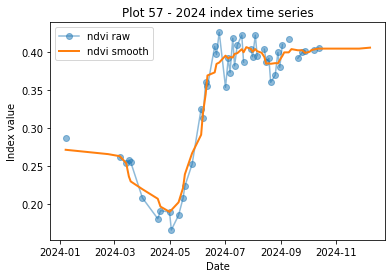

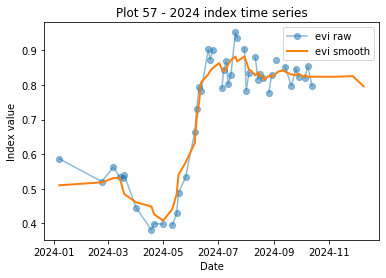

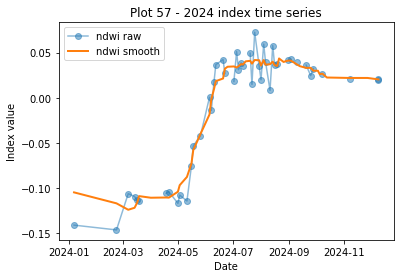

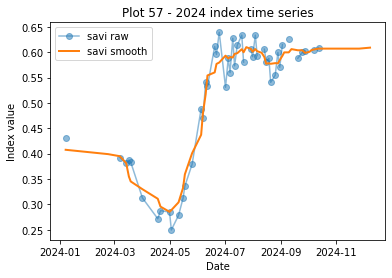

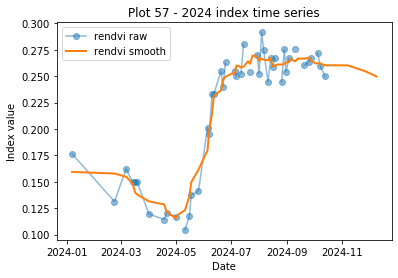

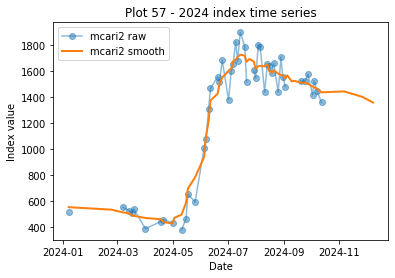

In [21]:
import matplotlib.pyplot as plt

plot_id = 57    # example plot
year = 2024    # example year

df_plot = df[(df['plot_id']==plot_id) & (df['date'].dt.year==year)].sort_values('date')

indices = ['ndvi','evi','ndwi','savi','rendvi','mcari2']

# plt.figure(figsize=(14,6))
for idx in indices:
    plt.plot(df_plot['date'], df_plot[idx], 'o-', alpha=0.5, label=f'{idx} raw')
    sm = idx + '_smooth'
    if sm in df_plot.columns:
        plt.plot(df_plot['date'], df_plot[sm], '-', lw=2, label=f'{idx} smooth')
    plt.title(f'Plot {plot_id} - {year} index time series')
    plt.xlabel('Date')
    plt.ylabel('Index value')
    plt.legend()
    plt.show()


In [57]:
# ---------- helper functions ----------
def ensure_datetime(df, date_col='date'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    return df.sort_values([ 'plot_id', date_col ])

def year_of_row(df, date_col='date'):
    return df[date_col].dt.year

def season_group(df, date_col='date'):
    # Group by plot-year
    df = df.copy()
    df['year'] = df[date_col].dt.year
    return df

def area_under_curve(x, y):
    # x: array of ordinal dates (or integers), y: values
    # return trapezoidal AUC; handle NaNs by masking
    mask = np.isfinite(y)
    if mask.sum() < 2:
        return np.nan
    return float(np.trapz(y[mask], x[mask]))

def running_slope(series, window=7):
    '''
    Compute slope (per day) using linear regression on rolling windows.
    Ensures no NaNs remain by backfilling/forward-filling.
    '''
    from sklearn.linear_model import LinearRegression

    arr = series.values
    n = len(arr)
    slopes = np.full(n, np.nan)

    for i in range(n):
        start = max(0, i - window + 1)
        y = arr[start:i+1]
        if np.isfinite(y).sum() < 2:
            continue  # leave NaN for now
        X = np.arange(len(y)).reshape(-1,1)
        lr = LinearRegression().fit(X, np.nan_to_num(y))
        slopes[i] = lr.coef_[0]

    # ---- Option B: fill missing slopes by interpolation or flat extension ----
    slopes = pd.Series(slopes).bfill().ffill().values

    return slopes




# ---------- core aggregation function (all metrics slopes) ----------
def aggregate_plot_year(df, date_col='date', plot_col='plot_id',
                                   smooth_prefix='_smooth', late_window_days=30,
                                   slope_window=7):
    '''
    Returns one row per (plot_id, year) with:
    - seasonal statistics per metric (mean, std, max, min)
    - seasonal early/mid/late slopes per metric
    - late-window statistics per metric (mean, median, max, min, auc, end_slope)
    '''
    df = ensure_datetime(df, date_col)
    df = season_group(df, date_col)
    
    numeric_cols = [c for c in df.columns if c not in [date_col, plot_col, 'year']]
    smoothed_cols = [c for c in numeric_cols if c.endswith(smooth_prefix)]
    
    base_vars = [c.replace(smooth_prefix,'') for c in smoothed_cols] or \
                [c for c in numeric_cols if not c.endswith(smooth_prefix)]
    
    def choose_col(base):
        sm = base + smooth_prefix
        return sm if sm in df.columns else base

    groups = []
    for (plot, year), g in df.groupby([plot_col, 'year']):
        g = g.sort_values(date_col).reset_index(drop=True)
        if g.shape[0] < 5:
            continue
        
        g['doy'] = g[date_col].dt.dayofyear
        x = g['doy'].values
        row = {'plot_id': plot, 'year': year, 'n_days': len(g)}

        # --- phenology & seasonal slopes ---
        for v in base_vars:
            col = choose_col(v)
            y = g[col].values
            # basic stats
            row[f'{v}_season_mean'] = float(np.nanmean(y)) if np.isfinite(y).any() else np.nan
            row[f'{v}_season_std']  = float(np.nanstd(y))  if np.isfinite(y).any() else np.nan
            row[f'{v}_season_max']  = float(np.nanmax(y))  if np.isfinite(y).any() else np.nan
            row[f'{v}_season_min']  = float(np.nanmin(y))  if np.isfinite(y).any() else np.nan
            
            # seasonal early/mid/late slopes
            n = len(y)
            slices = [
                slice(0, max(2,n//3)),
                slice(max(1,n//3), max(2,2*n//3)),
                slice(max(2,2*n//3), n)
            ]
            slope_names = ['early','mid','late']
            for sl, name in zip(slices, slope_names):
                vals = y[sl]
                if np.isfinite(vals).sum() < 2:
                    slope = np.nan
                else:
                    dy = vals[-1] - vals[0]
                    dx = x[sl][-1] - x[sl][0] if x[sl][-1] != x[sl][0] else np.nan
                    slope = float(dy/dx) if np.isfinite(dx) else np.nan
                row[f'{v}_slope_{name}'] = slope

        # --- ndvi decline / veraison proxy ---
        ndvi_col = choose_col('ndvi_smooth')
        ndvi = g[ndvi_col].values
        try:
            i_max = np.nanargmax(ndvi)
        except ValueError:
            i_max = 0
        slopes7 = running_slope(pd.Series(ndvi), window=slope_window)
        decline_idx = None
        k = 3
        for idx in range(i_max+1, len(slopes7)):
            if idx+k-1 < len(slopes7) and np.all(slopes7[idx:idx+k] < 0):
                decline_idx = idx
                break
        if decline_idx is None:
            decline_idx = i_max
        row['decline_doy'] = int(g.loc[decline_idx,'doy'])
        row['decline_ndvi'] = float(ndvi[decline_idx])
        
        # --- late-window features ---
        cutoff_doy = g.loc[decline_idx,'doy'] + late_window_days
        late_mask = (g['doy'] >= g.loc[decline_idx,'doy']) & (g['doy'] <= cutoff_doy)
        row['late_n_obs'] = int(late_mask.sum())
        
        for v in base_vars:
            col = choose_col(v)
            vals = g.loc[late_mask, col].values
            if np.isfinite(vals).any():
                row[f'{v}_late_mean'] = float(np.nanmean(vals))
                row[f'{v}_late_median'] = float(np.nanmedian(vals))
                row[f'{v}_late_max'] = float(np.nanmax(vals))
                row[f'{v}_late_min'] = float(np.nanmin(vals))
                row[f'{v}_late_auc'] = area_under_curve(g.loc[late_mask,'doy'].values, vals)
                # end-of-late-window slope
                if len(vals) >= 3:
                    row[f'{v}_late_end_slope'] = float(running_slope(pd.Series(vals), window=min(slope_window,len(vals)))[-1])
                else:
                    row[f'{v}_late_end_slope'] = 0.0  # fill small late windows with 0 slope
            else:
                for suffix in ['mean','median','max','min','auc','end_slope']:
                    row[f'{v}_late_{suffix}'] = np.nan
        
        groups.append(row)
    
    agg_df = pd.DataFrame(groups)
    agg_df = agg_df.loc[:, agg_df.notna().any(axis=0)]
    return agg_df

# ---------- usage ----------
# agg = aggregate_plot_year(df)
# agg.to_csv('plot_year_features.csv', index=False)

In [58]:
agg = aggregate_plot_year(df)

In [59]:
# agg = agg.drop(agg[agg['n_days'] < 40].index)

# agg = agg.drop(agg[agg['ndvi_late_end_slope'].isna()].index)

# len(agg)

In [60]:
agg[agg['ndvi_slope_late'].isna()]

,plot_id,year,n_days,ndvi_season_mean,ndvi_season_std,ndvi_season_max,ndvi_season_min,ndvi_slope_early,ndvi_slope_mid,ndvi_slope_late,evi_season_mean,evi_season_std,evi_season_max,evi_season_min,evi_slope_early,evi_slope_mid,evi_slope_late,ndwi_season_mean,ndwi_season_std,ndwi_season_max,ndwi_season_min,ndwi_slope_early,ndwi_slope_mid,ndwi_slope_late,savi_season_mean,savi_season_std,savi_season_max,savi_season_min,savi_slope_early,savi_slope_mid,savi_slope_late,rendvi_season_mean,rendvi_season_std,rendvi_season_max,rendvi_season_min,rendvi_slope_early,rendvi_slope_mid,rendvi_slope_late,mcari2_season_mean,mcari2_season_std,mcari2_season_max,mcari2_season_min,mcari2_slope_early,mcari2_slope_mid,mcari2_slope_late,decline_doy,decline_ndvi,late_n_obs,ndvi_late_mean,ndvi_late_median,ndvi_late_max,ndvi_late_min,ndvi_late_auc,ndvi_late_end_slope,evi_late_mean,evi_late_median,evi_late_max,evi_late_min,evi_late_auc,evi_late_end_slope,ndwi_late_mean,ndwi_late_median,ndwi_late_max,ndwi_late_min,ndwi_late_auc,ndwi_late_end_slope,savi_late_mean,savi_late_median,savi_late_max,savi_late_min,savi_late_auc,savi_late_end_slope,rendvi_late_mean,rendvi_late_median,rendvi_late_max,rendvi_late_min,rendvi_late_auc,rendvi_late_end_slope,mcari2_late_mean,mcari2_late_median,mcari2_late_max,mcari2_late_min,mcari2_late_auc,mcari2_late_end_slope
53,5,2024,58,0.388888,0.050155,0.459704,0.261205,0.000769,-0.000193,NaN,0.843608,0.129233,0.980216,0.545962,0.000912,0.001511,NaN,0.018632,0.054533,0.064400,-0.107285,0.001055,0.000090,-0.000046,0.583245,0.075226,0.689462,0.391750,0.001153,-0.000289,NaN,0.255589,0.043309,0.303342,0.160144,0.000532,0.000155,NaN,1188.404423,417.687454,1606.093190,242.049637,6.071104,2.051770,-11.575582,174,0.408454,10,0.409391,0.409322,0.411677,0.407966,12.276123,0.000480,0.869646,0.864063,0.898751,0.854340,26.060184,0.008153,0.046486,0.049585,0.052562,0.036050,1.376560,0.000393,0.614008,0.613904,0.617433,0.611870,18.411814,0.000719,0.279128,0.281431,0.285531,0.269341,8.355252,0.001405,1535.427322,1552.691583,1597.076863,1470.594719,45849.779451,7.859084
62,6,2024,58,0.412026,0.053723,0.483098,0.276456,0.000551,-0.000666,NaN,0.893316,0.127051,1.090594,0.595566,0.001646,-0.001894,NaN,0.049514,0.048472,0.089874,-0.049822,0.000752,-0.000011,-0.000199,0.617961,0.080581,0.724561,0.414627,0.000827,-0.000999,NaN,0.281359,0.048081,0.324256,0.172092,0.000557,-0.000047,NaN,1729.804626,562.818139,2323.685675,671.684287,9.191066,-3.367224,NaN,184,0.447831,11,0.440106,0.439646,0.447831,0.432661,13.204408,-0.000309,0.960941,0.958228,0.987065,0.929619,28.792769,0.004124,0.079574,0.080675,0.084358,0.072562,2.408079,0.000687,0.660086,0.659397,0.671673,0.648920,19.804418,-0.000463,0.316647,0.318203,0.322498,0.306062,9.522730,0.000300,2222.278372,2225.262155,2302.867671,2144.099625,66608.531120,-16.948917
71,7,2024,58,0.424185,0.063793,0.505582,0.281051,0.000796,-0.000972,NaN,0.871204,0.151840,1.094977,0.571216,0.001514,-0.001812,-0.002149,0.024493,0.056247,0.090019,-0.092694,0.000767,-0.000261,-0.000163,0.636194,0.095683,0.758278,0.421514,0.001193,-0.001458,NaN,0.282589,0.053151,0.346657,0.169626,0.000698,-0.000459,NaN,1722.269582,619.431956,2551.785083,619.686836,9.028925,-4.931083,NaN,189,0.496193,11,0.489070,0.492912,0.499522,0.471941,14.722073,-0.004558,1.060265,1.067486,1.094977,1.016447,32.016961,-0.009984,0.081974,0.084309,0.090019,0.062762,2.509025,-0.003779,0.733514,0.739279,0.749188,0.707824,22.080383,-0.006836,0.336211,0.335312,0.346657,0.330090,10.114659,-0.001685,2406.002585,2422.631902,2551.785083,2222.829218,72553.594209,-42.570790
80,8,2024,58,0.405706,0.069436,0.509222,0.258204,0.001484,-0.000761,NaN,0.873348,0.159887,1.144702,0.519951,0.003958,-0.001671,NaN,0.009829,0.067820,0.075776,-0.151087,0.001374,-0.000044,-0.000029,0.608477,0.104150,0.763736,0.387240,0.002227,-0.001142,NaN,0.275878,0.054039,0.352732,0.163971,0.001108,-0.000357,NaN,1586.905705,591.031314,2521.940952,467.501796,12.945408,-5.560108,-10.870773,177,0.461657,10,0.42

In [61]:
agg[agg['ndvi_late_auc'].isna()]

,plot_id,year,n_days,ndvi_season_mean,ndvi_season_std,ndvi_season_max,ndvi_season_min,ndvi_slope_early,ndvi_slope_mid,ndvi_slope_late,evi_season_mean,evi_season_std,evi_season_max,evi_season_min,evi_slope_early,evi_slope_mid,evi_slope_late,ndwi_season_mean,ndwi_season_std,ndwi_season_max,ndwi_season_min,ndwi_slope_early,ndwi_slope_mid,ndwi_slope_late,savi_season_mean,savi_season_std,savi_season_max,savi_season_min,savi_slope_early,savi_slope_mid,savi_slope_late,rendvi_season_mean,rendvi_season_std,rendvi_season_max,rendvi_season_min,rendvi_slope_early,rendvi_slope_mid,rendvi_slope_late,mcari2_season_mean,mcari2_season_std,mcari2_season_max,mcari2_season_min,mcari2_slope_early,mcari2_slope_mid,mcari2_slope_late,decline_doy,decline_ndvi,late_n_obs,ndvi_late_mean,ndvi_late_median,ndvi_late_max,ndvi_late_min,ndvi_late_auc,ndvi_late_end_slope,evi_late_mean,evi_late_median,evi_late_max,evi_late_min,evi_late_auc,evi_late_end_slope,ndwi_late_mean,ndwi_late_median,ndwi_late_max,ndwi_late_min,ndwi_late_auc,ndwi_late_end_slope,savi_late_mean,savi_late_median,savi_late_max,savi_late_min,savi_late_auc,savi_late_end_slope,rendvi_late_mean,rendvi_late_median,rendvi_late_max,rendvi_late_min,rendvi_late_auc,rendvi_late_end_slope,mcari2_late_mean,mcari2_late_median,mcari2_late_max,mcari2_late_min,mcari2_late_auc,mcari2_late_end_slope
18,2,2016,19,0.490261,0.082470,0.589640,0.282139,0.001533,0.000493,-0.001063,1.091674,0.203359,1.299538,0.619797,0.003546,0.001966,-0.002469,0.056499,0.063078,0.125115,-0.079513,0.000699,0.001482,0.000006,0.735274,0.123691,0.884306,0.423118,0.002300,0.000739,-0.001595,0.335412,0.064176,0.374809,0.163612,0.001305,0.000162,-0.000240,1827.450194,575.703297,2552.683830,719.731935,7.157397,10.053520,-11.262746,309,0.514668,1,0.514668,0.514668,0.514668,0.514668,NaN,0.0,1.186565,1.186565,1.186565,1.186565,NaN,0.0,0.106104,0.106104,0.106104,0.106104,NaN,0.0,0.771867,0.771867,0.771867,0.771867,NaN,0.0,0.355407,0.355407,0.355407,0.355407,NaN,0.0,1604.948377,1604.948377,1604.948377,1604.948377,NaN,0.0
36,4,2016,19,0.490748,0.011883,0.507053,0.454886,NaN,-0.000786,0.000212,1.058039,0.034251,1.093926,0.934478,NaN,-0.000531,-0.000105,0.101586,0.010748,0.126020,0.087824,NaN,-0.000222,0.000266,0.736023,0.017822,0.760468,0.682235,NaN,-0.001179,0.000317,0.293487,0.060539,0.353489,0.122298,0.001471,-0.000673,-0.000897,1571.955988,620.752525,2488.873804,600.879604,8.839151,-5.405643,-11.127683,359,0.507053,1,0.507053,0.507053,0.507053,0.507053,NaN,0.0,1.042581,1.042581,1.042581,1.042581,NaN,0.0,0.126020,0.126020,0.126020,0.126020,NaN,0.0,0.760468,0.760468,0.760468,0.760468,NaN,0.0,0.214711,0.214711,0.214711,0.214711,NaN,0.0,660.215067,660.215067,660.215067,660.215067,NaN,0.0
118,13,2017,30,0.280458,0.047679,0.325740,0.149353,0.001101,0.000463,0.000136,0.608851,0.086513,0.752527,0.456891,0.001498,0.001095,-0.001533,-0.023646,0.042849,0.035389,-0.116979,0.000934,0.000557,-0.000857,0.420634,0.071510,0.488533,0.224001,0.001651,0.000694,0.000204,0.177886,0.024733,0.203394,0.122328,0.000527,-0.000555,0.000126,813.375261,177.467965,1037.608486,436.232667,4.474849,-3.480460,-1.524005,340,0.325740,1,0.325740,0.325740,0.325740,0.325740,NaN,0.0,0.578518,0.578518,0.578518,0.578518,NaN,0.0,-0.058519,-0.058519,-0.058519,-0.058519,NaN,0.0,0.488533,0.488533,0.488533,0.488533,NaN,0.0,0.191565,0.191565,0.191565,0.191565,NaN,0.0,712.930917,712.930917,712.930917,712.930917,NaN,0.0
140,15,2021,60,0.150278,0.027592,0.244999,0.110646,0.000281,0.000246,0.000918,0.328121,0.072217,0.612022,0.234024,0.001044,0.000255,0.002828,-0.081476,0.015745,-0.024456,-0.110977,0.000236,0.000180,0.000510,0.225391,0.041384,0.367453,0.165950,0.000422,0.000369,0.001376,0.087601,0.014527,0.114361,0.066811,0.000159,0.000089,0.000176,331.382717,84.916019,526.984535,182.433229,1.536628,0.624451,1.635738,317,0.244999,1,0.244999,0.244999,0.244999,0.244999,NaN,0.0,0.612022,0.612022,0.612022,0.612022,NaN,0.0,-0.024456,-0.024456,-0.024456,-0.024456,NaN,0.0,0.367453,0.367453,0.367453,0.3

In [66]:
agg = agg.dropna()

In [67]:
agg

,plot_id,year,n_days,ndvi_season_mean,ndvi_season_std,ndvi_season_max,ndvi_season_min,ndvi_slope_early,ndvi_slope_mid,ndvi_slope_late,evi_season_mean,evi_season_std,evi_season_max,evi_season_min,evi_slope_early,evi_slope_mid,evi_slope_late,ndwi_season_mean,ndwi_season_std,ndwi_season_max,ndwi_season_min,ndwi_slope_early,ndwi_slope_mid,ndwi_slope_late,savi_season_mean,savi_season_std,savi_season_max,savi_season_min,savi_slope_early,savi_slope_mid,savi_slope_late,rendvi_season_mean,rendvi_season_std,rendvi_season_max,rendvi_season_min,rendvi_slope_early,rendvi_slope_mid,rendvi_slope_late,mcari2_season_mean,mcari2_season_std,mcari2_season_max,mcari2_season_min,mcari2_slope_early,mcari2_slope_mid,mcari2_slope_late,decline_doy,decline_ndvi,late_n_obs,ndvi_late_mean,ndvi_late_median,ndvi_late_max,ndvi_late_min,ndvi_late_auc,ndvi_late_end_slope,evi_late_mean,evi_late_median,evi_late_max,evi_late_min,evi_late_auc,evi_late_end_slope,ndwi_late_mean,ndwi_late_median,ndwi_late_max,ndwi_late_min,ndwi_late_auc,ndwi_late_end_slope,savi_late_mean,savi_late_median,savi_late_max,savi_late_min,savi_late_auc,savi_late_end_slope,rendvi_late_mean,rendvi_late_median,rendvi_late_max,rendvi_late_min,rendvi_late_auc,rendvi_late_end_slope,mcari2_late_mean,mcari2_late_median,mcari2_late_max,mcari2_late_min,mcari2_late_auc,mcari2_late_end_slope
1,0,2017,30,0.464914,0.063468,0.528177,0.284905,0.000572,-0.001113,-0.001753,0.974555,0.146545,1.117828,0.544719,0.001992,-0.000950,-0.004990,0.069058,0.035049,0.115640,0.009794,0.000958,-0.000794,-0.000595,0.697290,0.095198,0.792178,0.427293,0.000859,-0.001670,-0.002630,0.306722,0.052673,0.367795,0.176396,0.001152,-0.000587,-0.001489,2230.144762,704.633645,3041.670786,703.108812,16.438022,-11.625544,-16.790347,200,0.511173,8,0.503383,0.501119,0.511173,0.499183,15.065067,-0.001394,1.065530,1.065943,1.073561,1.053587,31.954550,-0.002050,0.098036,0.095904,0.111094,0.086613,2.883386,-0.003415,0.754990,0.751595,0.766676,0.748687,22.595080,-0.002091,0.347783,0.347516,0.355891,0.342464,10.397368,-0.000380,2814.246957,2797.806569,2993.448838,2698.192673,83758.396181,-23.855535
2,0,2018,56,0.420465,0.061046,0.514380,0.254721,0.001885,-0.001216,-0.000529,0.916141,0.159346,1.139002,0.496051,0.004763,-0.000772,-0.003096,0.049519,0.032647,0.105984,-0.010138,0.000643,-0.000786,-0.000284,0.630619,0.091562,0.771480,0.382022,0.002827,-0.001824,-0.000794,0.277454,0.052350,0.350557,0.156791,0.001435,-0.000722,-0.000582,1784.568278,616.373742,2755.541199,539.510369,16.415043,-10.268961,-10.343103,190,0.488356,13,0.453767,0.452005,0.488356,0.431851,13.610861,-0.004095,1.013140,1.000291,1.075654,0.986274,30.338562,0.002099,0.074602,0.072738,0.095413,0.061449,2.234742,-0.002147,0.680572,0.677930,0.732448,0.647703,20.413928,-0.006142,0.317579,0.318917,0.347942,0.297663,9.526883,-0.003189,2282.771307,2248.314127,2527.661626,2115.606630,68424.253028,-21.356560
3,0,2019,54,0.347802,0.052432,0.400627,0.226743,0.000274,-0.000063,-0.000891,0.706080,0.126863,0.841124,0.410727,0.000342,0.000584,-0.002504,-0.013082,0.043682,0.042784,-0.100392,-0.000122,-0.000255,-0.001039,0.521638,0.078643,0.600874,0.340069,0.000412,-0.000094,-0.001336,0.226632,0.042537,0.275303,0.139371,0.000120,0.000306,-0.000968,1234.882780,415.002127,1695.724032,545.249454,4.872256,0.989884,-9.865876,200,0.392748,12,0.387433,0.385986,0.392748,0.382241,11.619039,0.001698,0.797147,0.794037,0.841124,0.761376,23.995516,0.009181,0.014853,0.012702,0.026238,0.008255,0.410174,-0.000358,0.581082,0.578913,0.589055,0.573293,17.426519,0.002547,0.266127,0.264693,0.274946,0.262735,7.981602,0.002356,1612.759467,1619.505336,1675.628070,1543.111080,48315.664217,25.258816
4,0,2020,60,0.328541,0.034262,0.381699,0.243754,0.000156,0.000429,-0.000576,0.658317,0.099325,0.813337,0.413419,0.000322,0.000445,-0.002041,-0.048834,0.021201,-0.020658,-0.089397,0.000298,0.000280,-0.000297,0.492746,0.051388,0.572468,0.365585,0.000233,0.000644,-0.000865,0.208273,0.029020,0.255185,0.151361,0.000057,0.000709,-0

In [68]:
pd.set_option('display.max_rows', len(agg.columns))

# now this will print every row
print(agg.isna().sum())

plot_id                  0
year                     0
n_days                   0
ndvi_season_mean         0
ndvi_season_std          0
ndvi_season_max          0
ndvi_season_min          0
ndvi_slope_early         0
ndvi_slope_mid           0
ndvi_slope_late          0
evi_season_mean          0
evi_season_std           0
evi_season_max           0
evi_season_min           0
evi_slope_early          0
evi_slope_mid            0
evi_slope_late           0
ndwi_season_mean         0
ndwi_season_std          0
ndwi_season_max          0
ndwi_season_min          0
ndwi_slope_early         0
ndwi_slope_mid           0
ndwi_slope_late          0
savi_season_mean         0
savi_season_std          0
savi_season_max          0
savi_season_min          0
savi_slope_early         0
savi_slope_mid           0
savi_slope_late          0
rendvi_season_mean       0
rendvi_season_std        0
rendvi_season_max        0
rendvi_season_min        0
rendvi_slope_early       0
rendvi_slope_mid         0
r

In [69]:
df['ndvi_smooth'].rolling(7, min_periods=3, center=True).mean()

0             NaN
1        0.535509
2        0.534119
3        0.531781
4        0.530001
           ...   
28725    0.382472
28726    0.376284
28727    0.373168
28728    0.370845
28729    0.370936
Name: ndvi_smooth, Length: 28730, dtype: float64

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year
0,2016-02-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
1,2016-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.946759,0.070016,NaN,NaN,1883.327808,2016
2,2016-04-25,0,NaN,NaN,NaN,NaN,NaN,NaN,0.541043,1.061737,0.070016,0.811470,0.385737,2558.981310,2016
3,2016-05-08,0,NaN,NaN,NaN,NaN,NaN,NaN,0.535148,1.070415,0.075426,0.802627,0.376227,2669.552020,2016
4,2016-05-28,0,NaN,0.946759,0.070016,NaN,NaN,1883.327808,0.530336,1.080529,0.075303,0.795410,0.371284,2694.267480,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28725,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.370482,0.792014,0.012630,0.555655,0.217763,971.908163,2024
28726,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.380528,0.757642,0.004214,0.570719,0.217073,782.366905,2024
28727,2024-11-27,64,NaN,0.824603,0.000976,NaN,0.157318,524.747433,0.370877,0.750294,0.001871,0.556243,0.204643,656.014303,2024
28728,2024-12-09,64,NaN,NaN,NaN,NaN,NaN,85.399354,0.368285,0.731293,0.004955,0.552355,0.191950,539.137548,2024


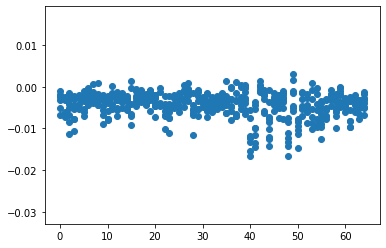

In [70]:
plt.scatter(agg['plot_id'], [agg['evi_slope_late']])

In [20]:
crash()

NameError: name 'crash' is not defined

### Now we can compute statistics for our plot-year ndvi data

#### Compute across year statistics -- save for later analysis

In [ ]:
stats = []
for key, group in df.groupby('plot_id'):
    # print(key, group)
    for yr, data in group.groupby('year'):
        # print(data)
        variance = np.var(data['ndvi'])
        mean = np.mean(data['ndvi'])
        n = len(data['ndvi'])
        stats.append({
            'year':yr,
            'plot':key,
            'mean':mean,
            'variance':variance,
            'n':n
        })
ndvi_stats = pd.DataFrame(stats)

In [ ]:
ndvi_stats_gdf = ndvi_stats.merge(
    vineyard[['geometry']],  # keep just geometry
    left_on='plot',
    right_index=True
)

In [ ]:
across_year = (
    ndvi_stats
    .groupby('plot')
    .agg(
        mean_of_means=('mean', 'mean'),
        var_of_means=('mean', 'var'),
        mean_of_variance=('variance', 'mean')
    )
)


across_year.to_pickle('data/ndvi/plots/agg_stats.pkl')

In [ ]:
aligned_dfs = []
for df in df_list:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    # optional: keep only growing season
    # df = df[(df['doy'] >= 90) & (df['doy'] <= 300)]
    
    # Aggregate multiple observations per day
    df_daily = df.groupby('doy')['ndvi'].mean().reset_index()
    
    year = df['date'].dt.year.iloc[0]
    df_daily.rename(columns={'ndvi_smooth': year}, inplace=True)
    aligned_dfs.append(df_daily)


In [ ]:
from functools import reduce

df_all = reduce(lambda left, right: pd.merge(left, right, on='doy', how='outer'), aligned_dfs)
df_all.set_index('doy', inplace=True)

# Sort by DOY to get a proper seasonal curve
df_all.sort_index(inplace=True)


In [ ]:
df_all

In [ ]:
mean_ndvi = df_all.mean(axis=1)
std_ndvi = df_all.std(axis=1)
n_years = df_all.shape[1]

ci_upper = mean_ndvi + 1.96 * std_ndvi / np.sqrt(n_years)
ci_lower = mean_ndvi - 1.96 * std_ndvi / np.sqrt(n_years)


In [ ]:
window = 14  # days
mean_smooth = mean_ndvi.rolling(window, center=True, min_periods=1).mean()
ci_upper_smooth = ci_upper.rolling(window, center=True, min_periods=1).mean()
ci_lower_smooth = ci_lower.rolling(window, center=True, min_periods=1).mean()


In [ ]:
df

In [ ]:
doy_grid = np.arange(0, 365)  # 1 to 365


year_arrays = []

for df in df_list:
    # if df['year'][0] != 2025:
    #     continue
    df = df.copy()
    df['doy'] = pd.to_datetime(df['date']).dt.dayofyear
    # Drop duplicate DOYs to avoid reindexing errors
    df = df.drop_duplicates(subset='doy')
    
    # Interpolate onto full grid
    s = pd.Series(df['ndvi_smooth'].values, index=df['doy'])
    s_interp = s.reindex(doy_grid).interpolate(method='linear', limit_direction='both')
    year_arrays.append(s_interp.values)

In [ ]:
year_matrix = np.vstack(year_arrays)  # shape: (n_years, 365)

# Compute mean and standard deviation across years
mean_ndvi = np.nanmean(year_matrix, axis=0)
std_ndvi = np.nanstd(year_matrix, axis=0)

# Smooth with rolling window
window = 14  # roughly 2 weeks
mean_smooth = pd.Series(mean_ndvi).rolling(window, center=True, min_periods=1).mean().values
std_smooth = pd.Series(std_ndvi).rolling(window, center=True, min_periods=1).mean().values

# 95% confidence interval
ci_upper = mean_smooth + 1.96 * std_smooth
ci_lower = mean_smooth - 1.96 * std_smooth

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

all_ndvi = []
# Define DOY grids
doy_full = np.arange(0, 367)  # full year
# doy_full_2025 = np.arange(0, 269)     # clip 2025 at day 266
plt.figure(figsize=(10, 8))
def is_inverted(df_plot):
    early = df_plot[df_plot['date'].dt.dayofyear < 180]['ndvi'].mean()
    late  = df_plot[df_plot['date'].dt.dayofyear >= 180]['ndvi'].mean()
    return early > late

for n, df in enumerate(df_list):
# df = df_list[7].copy()
    # print(n)
    # if n == 7:
    #     continue
# For each plot

    inverted_plots = df.groupby('plot_id').filter(is_inverted)['plot_id'].unique()
    print('Plots likely inverted:', inverted_plots)


    # for pid in inverted_plots:
    #     mask = df['plot_id'] == pid
    #     df.loc[mask, 'ndvi'] = df.loc[mask, 'ndvi'].iloc[::-1].values
    #     df.loc[mask, 'ndvi_smooth'] =df.loc[mask, 'ndvi_smooth'].iloc[::-1].values

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    # if df['year'].mean() != 2025:
    #     continue
    # print(df)
    df['doy'] = df['date'].dt.dayofyear
    df['ndvi_smooth'] = df['ndvi'].rolling(window = 14, center=True, min_periods=1).mean()

    # Skip very low ndvi plots
    # if np.mean(df['ndvi_smooth']) < 0.2:
    #     continue

    # df = df.drop(drop_index)
    plot_id = df.get('plot_id', None)

    # Group by plot and year
    if plot_id is not None:
        group_cols = ['plot_id', 'year']
    else:
        # fallback: treat entire df as one plot
        df['plot_id'] = 0
        group_cols = ['plot_id', 'year']

    # 
    # doy_full = doy_full_2025 ifdf['year'].iloc[0] == 2025 else doy_full_default

    for (p_id, year), group in df.groupby(group_cols):
        # Aggregate duplicates per DOY
        group_agg = group.groupby('doy', as_index=False)['ndvi_smooth'].mean()

        # Reindex to full DOY and interpolate missing values
        group_interp = group_agg.set_index('doy').reindex(doy_full)
        group_interp['ndvi_smooth'] = group_interp['ndvi_smooth'].interpolate()
    #     if group_interp.loc[365].values[0] < 0.18:
    #         continue

    #     if group_interp.loc[365].values[0] > 0.27:
    #         continue
        # Plot per plot-year
        label = f'Plot {p_id} - {year}'
        plt.plot(doy_full, group_interp['ndvi_smooth'], alpha=0.3, color='#1f77b4',)

        all_ndvi.append(group_interp['ndvi_smooth'].values)
        
# Compute mean and 95% CI across all plot-years
# Convert all_ndvi to 2D array and compute mean + CI
all_ndvi_series = [pd.Series(a) for a in all_ndvi]  # convert each to Series
all_ndvi_df = pd.concat(all_ndvi_series, axis=1)   # columns = plot-years
mean_smooth = all_ndvi_df.mean(axis=1)
ci_lower = all_ndvi_df.quantile(0.025, axis=1)
ci_upper = all_ndvi_df.quantile(0.975, axis=1)
# mean_smooth = np.nanmean(all_ndvi, axis=0)
# ci_lower = np.nanpercentile(all_ndvi, 2.5, axis=0)
# ci_upper = np.nanpercentile(all_ndvi, 97.5, axis=0)

# Plot mean ± 95% CI
# plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.5, label='95% CI')
# plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, label='Mean ndvi (smoothed)')
plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# for df_values in all_ndvi:
#     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
plt.xlabel('Day of Year', fontsize=16)
plt.ylabel('ndvi', fontsize=16)
plt.title('Regression Ridge ndvi Seasonal Cycle (per plot-year)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=12, loc='upper left')
plt.savefig('fig.png')
plt.show()


In [ ]:
ndvi = pd.DataFrame(all_ndvi)

In [ ]:
import pandas as pd
import numpy as np

# assume you have df with columns: plot_id, doy, ndvi

def is_inverted(curve):
    # Split ndvi by season (rough cut)
    spring = curve[(curve['doy'] >= 60) & (curve['doy'] <= 120)]['ndvi'].mean()
    summer = curve[(curve['doy'] >= 150) & (curve['doy'] <= 220)]['ndvi'].mean()
    fall   = curve[(curve['doy'] >= 230) & (curve['doy'] <= 270)]['ndvi'].mean()
    
    # Flag if summer ndvi is *lower* than both spring and fall
    return summer < spring and summer < fall

# Apply per plot-year
inverted_plots = []
for (plot, year), group in df.groupby(['plot_id','year']):
    if is_inverted(group):
        inverted_plots.append((plot, year))

print('Inverted plot-years:', inverted_plots)


In [ ]:
inverted_idx = [inverted_plots[i][0] for i in range(0, len(inverted_plots), 1)]

In [ ]:
df_ndvi = pd.DataFrame({
    'doy': doy_full,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [ ]:
# years = list(range(2016, 2026))  
rows_per_year = 65

for n, year in enumerate(years):
    start = n * rows_per_year
    end = (n + 1) * rows_per_year
    ndvi.loc[start:end-1, 'year'] = str(year)
    

In [ ]:
ndvi

In [ ]:
rows_per_year = 65
# years = list(range(2025, 2026))  
n_years = len(years)

# total rows should match df
assert ndvi.shape[0] == rows_per_year * n_years

# assign year
ndvi['year'] = np.repeat(years, rows_per_year)

# assign plot_id (repeats 0..64 for each year)
ndvi['plot_id'] = np.tile(np.arange(rows_per_year), n_years)


In [ ]:
ndvi_copy = ndvi.copy()

In [ ]:
ndvi = ndvi_copy.copy()

In [ ]:
ndvi

In [ ]:
import numpy as np
import pandas as pd

# Assume ndvi_df has columns: [0..364] for DOY, plus 'year', 'plot_id'

# Compute curve-level features
curve_stats = []
for idx, row in ndvi.iterrows():
    # Grab the first 365 columns (days of year ndvi values)
    ndvi_vals = row[0:366]
    # print(ndvi_vals)

    # ignore NaNs
    # ndvi_vals = ndvi_vals[~np.isnan(ndvi_vals)]
    if len(ndvi_vals) == 0:
        continue

#     if ndvi_vals[365] < 0.18:
#         continue
        
#     if ndvi_vals[365] > 0.27:
#         continue
        
        
        
    mean_val = np.mean(ndvi_vals)
    peak_val = np.max(ndvi_vals)
    min_val = np.min(ndvi_vals)
    amplitude = peak_val - min_val

    curve_stats.append({
        'index': idx,
        'mean': mean_val,
        'peak': peak_val,
        'amplitude': amplitude
    })

curve_stats = pd.DataFrame(curve_stats)

# === Define filters ===
mean_mean, mean_std = curve_stats['mean'].mean(), curve_stats['mean'].std()
mask_mean_outlier = ~curve_stats['mean'].between(mean_mean - 3.5*mean_std,
                                                 mean_mean + 3.5*mean_std)

peak_mean, peak_std = curve_stats['peak'].mean(), curve_stats['peak'].std()
mask_peak_outlier = ~curve_stats['peak'].between(peak_mean - 3.5*peak_std,
                                                 peak_mean + 3.5*peak_std)

mask_flat = curve_stats['amplitude'] < 0.161  # nearly flat curves

# Combine masks
bad_idx = curve_stats.loc[mask_mean_outlier | mask_peak_outlier | mask_flat, 'index']

# === Filter original wide table ===
ndvi_filtered = ndvi.drop(index=bad_idx)

print(f'Dropped {len(bad_idx)} outlier plot-years out of {len(ndvi)} total')


In [ ]:
ndvi_filtered

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,6))
# Extract DOY columns (all ints, except 'year')
doy_cols = [c for c in ndvi_filtered.columns if isinstance(c, (int, np.integer))]

# X-axis = DOY numbers
doy_full = np.arange(len(doy_cols))

filtered_ndvi = []

# Loop through rows
for idx, row in ndvi_filtered.iterrows():
    year = row['year']
    ndvi_values = row[doy_cols].values.astype(float)
    # print(doy_cols[:10], '…', doy_cols[-10:])

    # skip all-NaN rows
    if np.isnan(ndvi_values).all():
        continue
    if ndvi_values[200] < 0.2:
        continue
        
#     if ndvi_values[8] > 0.27:
#         continue
        
#     if ndvi_values[100] > 0.3:
#         continue
#     if ndvi_values[100] < 0.12:
#         continue
        
#     if ndvi_values[365] < 0.18:
#         continue
        
#     if ndvi_values[365] > 0.27:
        continue
    plt.plot(doy_full, ndvi_values, alpha=0.4, color='#1f77b4')
    filtered_ndvi.append(ndvi_values)
    
filtered_ndvi = np.array(filtered_ndvi)
mean_smooth = np.nanmean(filtered_ndvi, axis=0)
ci_lower = np.nanpercentile(filtered_ndvi, 2.5, axis=0)
ci_upper = np.nanpercentile(filtered_ndvi, 97.5, axis=0)

plt.xlabel('Day of Year')
plt.ylabel('ndvi (smoothed)')
plt.title('ndvi curves by plot-year')

plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# for df_values in all_ndvi:
#     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
plt.xlabel('Day of Year', fontsize=16)
plt.ylabel('ndvi', fontsize=16)
plt.title('Regression Ridge\nndvi Seasonal Cycle (per plot-year)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=12, loc='upper left')
plt.savefig('img/ndvi_spaghetti.png')
plt.show()
plt.show()







# # Compute mean and 95% CI across all plot-years

# # Plot mean ± 95% CI
# # plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.5, label='95% CI')
# # plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, label='Mean ndvi (smoothed)')
# plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
# plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# # for df_values in all_ndvi:
# #     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
# plt.xlabel('Day of Year', fontsize=16)
# plt.ylabel('ndvi', fontsize=16)
# plt.title('Regression Ridge ndvi Seasonal Cycle (per plot-year)', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.legend(fontsize=12, loc='upper left')
# # plt.savefig('fig.png')
# plt.show()


In [ ]:
ndvi_filtered

In [ ]:
print(np.nanmin(ndvi_filtered[doy_cols].values), np.nanmax(ndvi_filtered[doy_cols].values))


In [ ]:
df_ndvi = pd.DataFrame({
    'doy': doy_full,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [ ]:
df_ndvi

In [ ]:
# ndvi.to_pickle('data/plot_ndvi.pkl')

In [ ]:
ndvi_filtered.to_pickle('data/plot_ndvi_filtered.pkl')

In [ ]:
# ndvi_filtered.to_pickle('data/plot_ndvi_filtered_2025.pkl')